# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [7]:
import pandas as pd
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
#file_path = '../../05_src/data/forest+fires/forestfires.csv'
file_path = '/Users/lizyeo/DSI/scaling_to_production/05_src/data/forest+fires/forestfires.csv'
fires_dt = (pd.read_csv(file_path, header = None, names = columns))


# Get X and Y

Create the features data frame and target data.

In [9]:
X = fires_dt.drop(columns='area')
Y = fires_dt['area']


Y.head()

0    area
1       0
2       0
3       0
4       0
Name: area, dtype: object

In [10]:
X.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0
4,8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [11]:
# preproc1
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_cols = ['month','day']

preproc1 = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'),categorical_cols)

])

preproc1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [49]:
# preproc2
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# Define a non-linear transformation function
def nonlinear_transform(X):
    # Handle negative values by setting them to zero
    X = np.where(X < 0, 0, X)
    # Add a small constant to avoid sqrt of zero
    return np.sqrt(X + 1e-10)


#define the numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')), #handle missing values
    ('scaler', StandardScaler()),
    ('transform', FunctionTransformer(nonlinear_transform, validate=True))
])

#define the categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preproc2 = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

preproc2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('transform',
                                                  FunctionTransformer(func=<function nonlinear_transform at 0x1584991f0>,
                                                                      validate=True))]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [13]:
# Pipeline A = preproc1 + baseline

from sklearn.linear_model import LinearRegression

baseline_regressor = LinearRegression()

pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_regressor)
])

pipeline_A

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [59]:
# Pipeline B = preproc2 + baseline

baseline_regressor_B = LinearRegression()

pipeline_B = Pipeline([
    ('preprocessing',preproc2),
    ('regressor', baseline_regressor_B)
])

pipeline_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   FunctionTransformer(func=<function nonlinear_transform at 0x1584991f0>,
                                                                                       validate=True))]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [15]:
# Pipeline C = preproc1 + advanced model

from sklearn.ensemble import RandomForestClassifier

advanced_regressor_C = RandomForestClassifier()

pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', advanced_regressor_C)
])

pipeline_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestClassifier())])

In [54]:
# Pipeline D = preproc2 + advanced model

from sklearn.ensemble import GradientBoostingRegressor

advanced_regressor_D = GradientBoostingRegressor()

pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor',advanced_regressor_D)
])

pipeline_D

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   FunctionTransformer(func=<function nonlinear_transform at 0x1584991f0>,
                                                                                       validate=True))]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', GradientBoostingRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [19]:
#Pipeline A: preproc1 + baseline regressor (Linear Regression)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#split into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#define the parameter
param_grid_A = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

grid_search_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring= 'neg_mean_squared_error')
grid_search_A.fit(X_train, Y_train)

#get the best params and score
best_params_A = grid_search_A.best_params_
best_score_A = grid_search_A.best_score_

print("Best parameters for Pipeline A:",best_params_A)
print("Best score for Pipeline A:", best_score_A)

Best parameters for Pipeline A: {'regressor__fit_intercept': False, 'regressor__positive': True}
Best score for Pipeline A: -5229.156343070289


In [51]:
#Pipeline B: preproc2 + baseline regressor (Linear Regression)
#kept getting Nan values error, had to add some codes to troubleshoot

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#split into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Inspect the data before transformation
print("NaN values in X_train before transformation:")
print(X_train.isna().sum())

# Test the preprocessing pipeline on X_train
X_train_transformed = preproc2.fit_transform(X_train)

# Inspect the transformed data for NaNs
print("NaN values in transformed X_train:")
print(np.isnan(X_train_transformed).sum())

print("Transformation successful, no NaNs present in transformed data:", not np.isnan(X_train_transformed).any())

# Create the full pipeline with preprocessing and regressor
pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid_B = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

# Perform GridSearchCV
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
try:
    grid_search_B.fit(X_train, Y_train)
    # Get the best parameters and score
    best_params_B = grid_search_B.best_params_
    best_score_B = grid_search_B.best_score_

    print("Best parameters for Pipeline B:", best_params_B)
    print("Best score for Pipeline B:", best_score_B)
except ValueError as e:
    print("Error during GridSearchCV fitting:", e)


NaN values in X_train before transformation:
coord_x    0
coord_y    0
month      0
day        0
ffmc       0
dmc        0
dc         0
isi        0
temp       0
rh         0
wind       0
rain       0
dtype: int64
NaN values in transformed X_train:
0
Transformation successful, no NaNs present in transformed data: True
Best parameters for Pipeline B: {'regressor__fit_intercept': False, 'regressor__positive': True}
Best score for Pipeline B: -5139.423549210157


In [52]:
#Pipeline C: preproc1 + advanced regressor (Random Forest Regressor)

from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for GridSearchCV for Pipeline C
param_grid_C = {
    'regressor__n_estimators': [50, 100, 150, 200]
}

# Perform GridSearchCV for Pipeline C
grid_search_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring='neg_mean_squared_error')
grid_search_C.fit(X_train, Y_train)

# Get the best parameters and the best score
best_params_C = grid_search_C.best_params_
best_score_C = grid_search_C.best_score_

print("Best parameters for Pipeline C:", best_params_C)
print("Best score for Pipeline C (neg_mean_squared_error):", best_score_C)


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Pipeline C: {'regressor__n_estimators': 100}
Best score for Pipeline C (neg_mean_squared_error): -5296.569577129004


In [55]:
#Pipeline D: preproc2 + advanced regressor (Gradient Boosting Regressor)

from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid for GridSearchCV for Pipeline D
param_grid_D = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2, 0.3]
}

# Perform GridSearchCV for Pipeline D
grid_search_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring='neg_mean_squared_error')
grid_search_D.fit(X_train, Y_train)

# Get the best parameters and the best score
best_params_D = grid_search_D.best_params_
best_score_D = grid_search_D.best_score_

print("Best parameters for Pipeline D:", best_params_D)
print("Best score for Pipeline D (neg_mean_squared_error):", best_score_D)


Best parameters for Pipeline D: {'regressor__learning_rate': 0.05, 'regressor__n_estimators': 50}
Best score for Pipeline D (neg_mean_squared_error): -7196.033362722951


# Evaluate

+ Which model has the best performance?

#Pipeline B has the best performance as it has the lowest MSE -5139.42.


# Export

+ Save the best performing model to a pickle file.

In [56]:
import joblib

best_model = grid_search_B.best_estimator_

#save the model to a pickle file
joblib_file = "best_model_pipeline_B.pkl"
joblib.dump(best_model, joblib_file)



['best_model_pipeline_B.pkl']

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.
    The important features are 'day_wed' and 'day_fri'. 'day_wed' has a high positive SHAP value of 1.7 suggesting that Wednesday tend to increase the predicted area affected by forest fires by 1.7 units. 'day_fri' has a negative SHAP value of -0.5 suggesting that there tends to be a decrease in the predicted area on Fridays by 0.5 units.


    - In general, across the complete training set, which features are the most and least important.
    The most important features are 'day_wed' and 'day_fri' and the least important are 'coord_x', 'dmc', 'dc'.



+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?
I would remove the features with 0 SHAP value like 'month'. We can test by retraining the model without the 'month' feature and see if it improves the model performance.


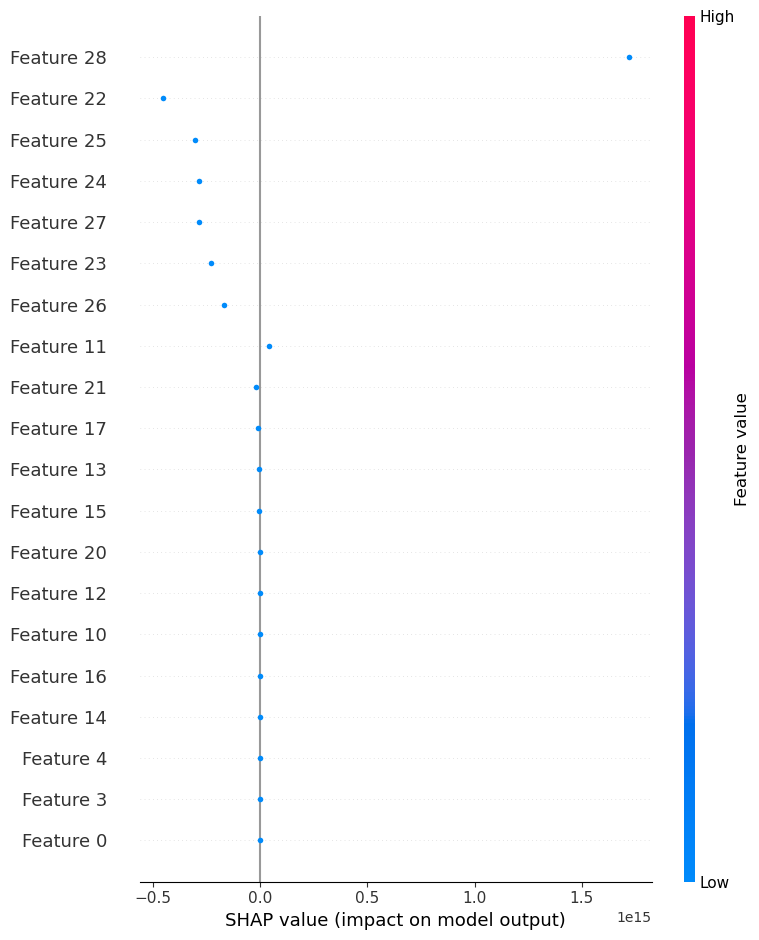

In [98]:
#Using SHAP on Pipeline B

import shap
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

# Drop headers for X, Y
X_noheaders = fires_dt.iloc[1:].drop(columns='area').values
Y_noheaders = fires_dt.iloc[1:]['area'].values

# Use indices instead
numerical_cols = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11] 
categorical_cols = [2, 3]

# Define a non-linear transformation function
def nonlinear_transform(X):
    # Handle negative values by setting them to zero
    X = np.where(X < 0, 0, X)
    # Add a small constant to avoid sqrt of zero
    return np.sqrt(X + 1e-10)

# numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),
    ('transform', FunctionTransformer(nonlinear_transform, validate=True))
])

# categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical preprocessing using ColumnTransformer
preproc2 = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_noheaders, Y_noheaders, test_size=0.2, random_state=42)

# Fit the preprocessing pipeline on training data and transform both training and test data
X_train_processed = preproc2.fit_transform(X_train)
X_test_processed = preproc2.transform(X_test)

# Define Pipeline B (preproc2 + baseline)
baseline_regressor_B = LinearRegression()

pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', baseline_regressor_B)
])

# Fit training data
pipeline_B.fit(X_train, Y_train)

# Create SHAP explainer
best_regressor_B = pipeline_B.named_steps['regressor']
explainer_B = shap.Explainer(best_regressor_B, X_train_processed)

# Select an observation from X_test
observation_idx = 9  # Use single index for observation

# Compute SHAP values
shap_values_B = explainer_B(X_test_processed[observation_idx:observation_idx+1])

# Plot the SHAP values
shap.summary_plot(shap_values_B)


In [101]:
# First row of X_noheaders
first_row = X_noheaders[0]

# Print the first row to visually inspect column names and order
print("First row of X_noheaders:\n", first_row)

# Verify numerical and categorical columns against the first row
print("\nNumerical columns:")
for idx in numerical_cols:
    print(idx, first_row[idx])

print("\nCategorical columns:")
for idx in categorical_cols:
    print(idx, first_row[idx])


First row of X_noheaders:
 ['7' '5' 'mar' 'fri' '86.2' '26.2' '94.3' '5.1' '8.2' '51' '6.7' '0']

Numerical columns:
0 7
1 5
4 86.2
5 26.2
6 94.3
7 5.1
8 8.2
9 51
10 6.7
11 0

Categorical columns:
2 mar
3 fri


In [102]:
# check the indices after one hot encoding since the plot shows more indices
numerical_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_cols = ['month', 'day']

# Calculate the total number of features
total_features = len(numerical_cols) + len(pd.get_dummies(fires_dt[categorical_cols], drop_first=True).columns)

# Generate feature names based on numerical and categorical columns
feature_names = numerical_cols + list(pd.get_dummies(fires_dt[categorical_cols], drop_first=True).columns)

# Display feature names and total features
print("Feature names:", feature_names)
print("Total features after one-hot encoding:", total_features)


Feature names: ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_month', 'month_nov', 'month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed']
Total features after one-hot encoding: 29


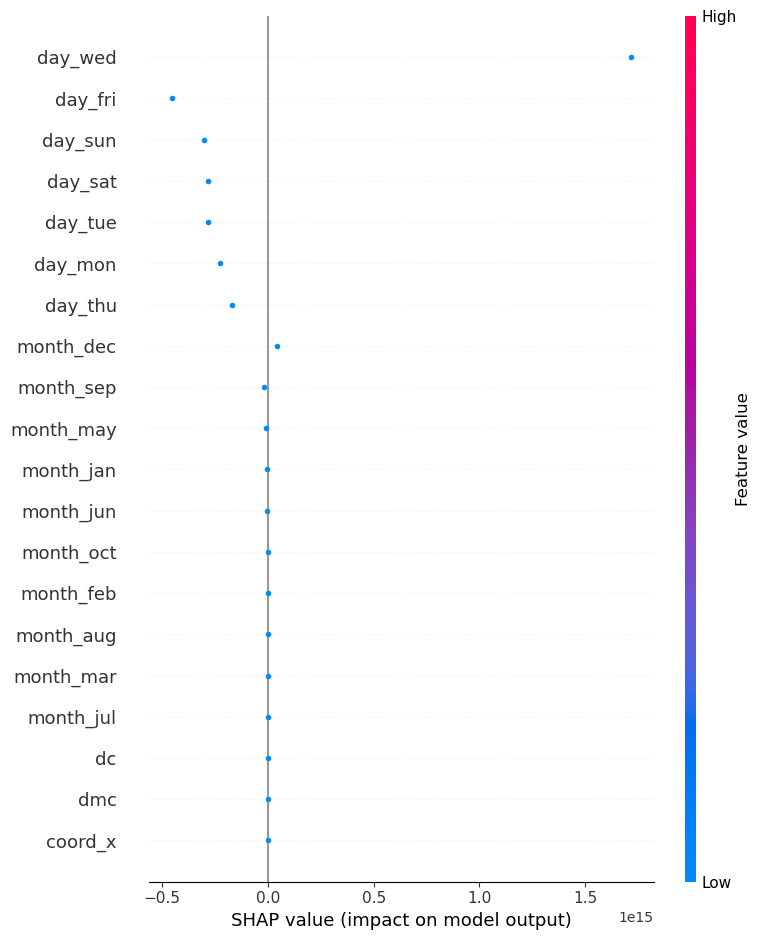

In [103]:
#plot SHAP again with feature names

import matplotlib.pyplot as plt
import shap


shap.summary_plot(shap_values_B, feature_names=feature_names)
plt.show()

*(Answer here.)*

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.